# chapter7

In [1]:
from scipy.special import comb

In [2]:
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier/2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1 - error)**(n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [3]:
import numpy as np
np.argmax(np.bincount([0 ,0, 1],
                      weights = [0.2, 0.2, 0.6]))

1

In [4]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [5]:
np.argmax(p)

0

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
x, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
x_train, x_test, y_train , y_test = train_test_split(x, y, 
                                                     test_size=0.5,
                                                     random_state=1,
                                                     stratify=y)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver = 'lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pip1 = Pipeline([['sc', StandardScaler()],
                ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic_regression', 'Decision tree', 'KNN']
for clf, label in zip([pip1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=x_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(scores.mean() , f'(+/- {scores.std():.2f}) [{label}]')

0.9166666666666666 (+/- 0.15) [Logistic_regression]
0.8666666666666668 (+/- 0.18) [Decision tree]
0.85 (+/- 0.13) [KNN]


In [12]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
        key: value for key,
        value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' "
            f"or 'classlabel'"
            f"; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
            f' weights must be equal'
            f'; got {len(self.weights)} weights,'
            f' {len(self.classifiers)} classifiers')
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([
            clf.predict(X) for clf in self.classifiers_
            ]).T
            maj_vote = np.apply_along_axis(
            lambda x: np.argmax(
            np.bincount(x, weights=self.weights)
            ),
            axis=1, arr=predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
        for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,
        weights=self.weights)
        return avg_proba
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(
                    deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [13]:
mv_clf = MajorityVoteClassifier(classifiers= [pip1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pip1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels) :
    scores = cross_val_score(estimator=clf,
                             X=x_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} ' f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic_regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


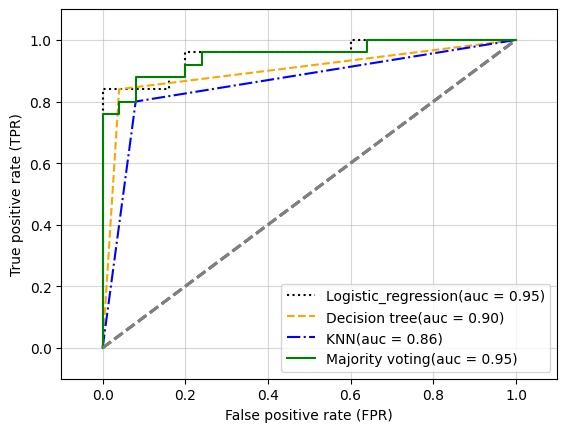

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linesstyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linesstyles):
    y_pred = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = f'{label}(auc = {roc_auc:.2f})')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'grey', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()


In [ ]:
sc = StandardScaler()
X_train_std = sc.fit_transform(x_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
sharex='col',
sharey='row',
figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
    X_train_std[y_train==0, 1],
    c='blue',
    marker='^',
    s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
    X_train_std[y_train==1, 1],
    c='green',
    marker='o',
    s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5.,
s='Sepal width [standardized]',
ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
s='Petal length [standardized]',
ha='center', va='center',
fontsize=12, rotation=90)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1,2],
          'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(x_train, y_train) 

In [ ]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

Bagging in a nutshell
aviod overfitting 
reducing variance

In [ ]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
'machine-learning-databases/'
'wine/wine.data',
header=None)
df_wine.columns = ['Class label', 'Alcohol',
'Malic acid', 'Ash',
'Alcalinity of ash',
'Magnesium', 'Total phenols',
'Flavanoids', 'Nonflavanoid phenols',
'Proanthocyanins',
'Color intensity', 'Hue',
'OD280/OD315 of diluted wines',
'Proline']
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
x = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion=1,
                              random_state=1,
                              max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs = 1,
                        random_state=1)

In [ ]:
from sklearn.metrics import accuracy_score
tree = tree.fit(x_train, y_train)
y_train_pred = tree.predict(x_test)
y_test_pred = tree.predict(x_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/{tree_test:.3f}')

In [ ]:
bag = bag.fit(x_train, y_train)
y_train_pred = bag.predict(x_train)
y_test_pred = bag.predict(x_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies '
f'{bag_train:.3f}/{bag_test:.3f}')

In [ ]:
x_min = x_train[:, 0].min() - 1
x_max = x_train[:, 0].max() + 1
y_min = x_train[:, 1].min() - 1
y_max = x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
sharex='col',
sharey='row',
figsize=(8, 3))
for idx, clf, tt in zip([0, 1],[tree, bag],['Decision tree', 'Bagging']):
    clf.fit(x_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(x_train[y_train==0, 0],
    x_train[y_train==0, 1],
    c='blue', marker='^')
    axarr[idx].scatter(x_train[y_train==1, 0],
    x_train[y_train==1, 1],
    c='green', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
s='OD280/OD315 of diluted wines',
ha='center',
va='center',
fontsize=12,
transform=axarr[1].transAxes)
plt.show()

adaboost
, diffrent weights for training dataset

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1,max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree = tree.fit(x_train, y_train)
y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/{tree_test:.3f}')

In [ ]:
ada = ada.fit(x_train, y_train)
y_train_pred = ada.predict(x_train)
y_test_pred = ada.predict(x_test)
ada_train = accuracy_score(y_train , y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies ' f'{ada_train:.3f}/{ada_test:.3f}')

In [ ]:
x_min = x_train[:, 0].min() - 1
x_max = x_train[:, 0].max() + 1
y_min = x_train[:, 1].min() - 1
y_max = x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
sharex='col',
sharey='row',
figsize=(8, 3))
for idx, clf, tt in zip([0, 1],[tree, bag],['Decision tree', 'Bagging']):
    clf.fit(x_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(x_train[y_train==0, 0],
    x_train[y_train==0, 1],
    c='blue', marker='^')
    axarr[idx].scatter(x_train[y_train==1, 0],
    x_train[y_train==1, 1],
    c='green', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
s='OD280/OD315 of diluted wines',
ha='center',
va='center',
fontsize=12,
transform=axarr[1].transAxes)
plt.show()